# Dr. Semmelweis and the discovery of handwashing 

### Introduction:
In this notebook, I would like to analyze a Kaggle dataset containing information about women who gave birth between 1841 and 1849. This data helped Dr. Ignác Semmelweis, a Hungarian physician working at a Vienna hospital, to make a breakthrough in the field of medicine. Before 1847, the significance of sterilization was not well recognized and approximately one in every ten women died after childbirth. Dr. Semmelweis's discovery significantly reduced the number of deaths linked to bacteria and childbed fever. During my analysis, I will explore the main relationships between the deaths and births in different clinics using statistics, pandas, Python, and various visualization libraries, which could help us address similar problems to those faced by Dr. Semmelweis.

### Step 1. Import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.dates import DateFormatter, MonthLocator
from scipy import stats as stats
import warnings

In [4]:
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)

### Step 2. Setting up the data

In [5]:
df_yearly = pd.read_csv('yearly_deaths_by_clinic.csv')
df_monthly = pd.read_csv('monthly_deaths.csv')

### Step 3. Data Exploration and Modification

In [6]:
print(f'Our yearly data includes {df_yearly.shape[0]} rows, from {df_yearly.year.nunique()} unique years, split up to two different clinics and {df_yearly.shape[1]} columns.')
print(f'Our monthly data includes {df_monthly.shape[0]} rows, from {df_monthly.date.str[0:4].nunique()} unique years, represented in {df_monthly.shape[1]} columns.' )

Our yearly data includes 12 rows, from 6 unique years, split up to two different clinics and 4 columns.
Our monthly data includes 98 rows, from 9 unique years, represented in 3 columns.


In [7]:
print(df_yearly.dtypes)
print('')
print('Monthly')
df_monthly.dtypes


year       int64
births     int64
deaths     int64
clinic    object
dtype: object

Monthly


date      object
births     int64
deaths     int64
dtype: object

##### Taking a look at the datatypes of the columns we are able to spot inappropiate types at the dates at each dataset. Let's change them to datetime64 for easier usability.

In [28]:
# df_yearly.year=pd.to_datetime(df_yearly.year, format='%Y')
# df_yearly.year = df_yearly.year.dt.to_period(freq='Y') - Way of converting year(int) to date, althought at this case period datatype is not the best to use for plotting.
df_monthly.date = pd.to_datetime(df_monthly['date'], format= '%Y-%m-%d')


##### Checking for duplicated, or NaN values in the datasets.

In [9]:
print(df_yearly.duplicated().any())
print(df_yearly.isna().values.any())
print(df_monthly.duplicated().any())
print(df_monthly.isna().values.any())

False
False
False
False


##### Splitting up the data by clinics for easier comparision.

In [10]:
clinic1 = df_yearly.loc[df_yearly['clinic'] == 'clinic 1', :]
clinic2 = df_yearly.loc[df_yearly['clinic'] == 'clinic 2', :]
clinic1.sample(5)


,year,births,deaths,clinic
3,1844,3157,260,clinic 1
4,1845,3492,241,clinic 1
0,1841,3036,237,clinic 1
1,1842,3287,518,clinic 1
5,1846,4010,459,clinic 1


### Step 4. Basic analitics 

In [11]:
df_monthly.describe(exclude=['datetime64'])

,births,deaths
count,98.00,98.00
mean,267.00,22.47
std,41.77,18.14
min,190.00,0.00
25%,242.50,8.00
50%,264.00,16.50
75%,292.75,36.75
max,406.00,75.00


In [22]:
df_yearly.iloc[:, 1:].describe()

,births,deaths
count,12.00,12.00
mean,3152.75,223.33
std,449.08,145.38
min,2442.00,66.00
25%,2901.75,100.25
50%,3108.50,219.50
75%,3338.25,263.50
max,4010.00,518.00


##### For the starting point of our analisis, comparing clinic1 and clinic2 death rates could give us a closer view where to locate the problem.

In [13]:
print(f' Death rates at clinic1 were {clinic1.deaths.sum() /clinic1.births.sum()*100:.2f} %.')
print(f' Death rates at clinic2 were {clinic2.deaths.sum() /clinic2.births.sum()*100:.2f} %.')


 Death rates at clinic1 were 9.92 %.
 Death rates at clinic2 were 3.88 %.


#####  By looking at the results we can see a significant difference between the numbers. We can start to break down the problem to different outcomes. It's possible that one of the clinics is busier and that's effect these rates. It might be connected to the period of the year somehow. To see the answers, we can plot the data.

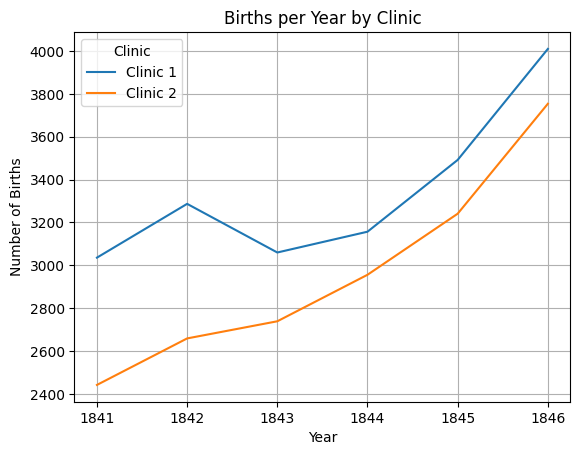

In [14]:
sns.lineplot(data=clinic1, x='year', y='births', label='Clinic 1')
sns.lineplot(data=clinic2, x='year', y='births', label='Clinic 2')

plt.xlabel("Year")
plt.ylabel("Number of Births")
plt.title("Births per Year by Clinic")
plt.legend(title='Clinic')
plt.grid()
plt.show()


##### By looking at the linechart we can see, that clinic1 generally giving birth to more children, but the difference not so significant during the studied years, that it could explain the difference in death rates. Let's see the changes of death rates during the months in 1841-1842.

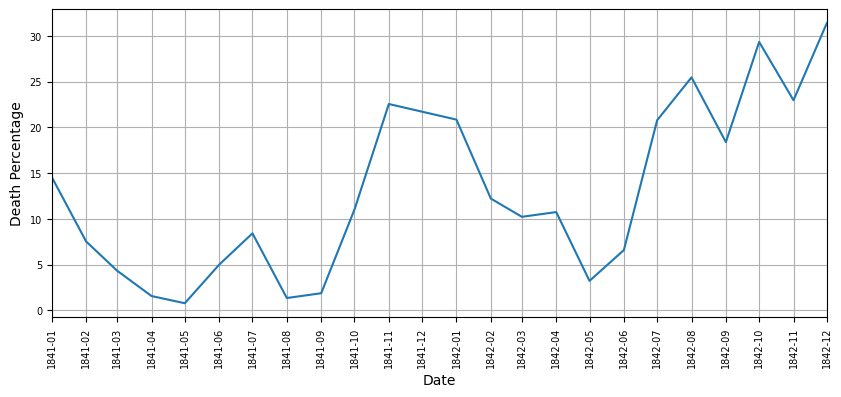

In [15]:
pd.option_context('mode.use_inf_as_na', True)
monthly_2years = df_monthly[df_monthly['date'] <= '1842-12-01']
monthly_2years['death_percentage'] = monthly_2years['deaths'] / monthly_2years['births'] * 100

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=monthly_2years, x='date', y='death_percentage')

ax.xaxis.set_major_locator(MonthLocator())
ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

ax.tick_params(axis='x', rotation=90, labelsize=7)
ax.grid(True)

ax.set_xlabel('Date', fontsize=10)
ax.set_ylabel('Death Percentage', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=7)
ax.set_xlim(min(monthly_2years['date']), max(monthly_2years['date']))

plt.show()

##### By looking at the results, we can spot, there is correlation between the number of cases during the summer and the winter months. This information could give us the first ideas about the moving of death rates. Maybe the growing number of sicknesses and viruses also affects the number of deaths amongst womens.

### Step 5. Start of handwashing

##### To see the power of sterilization, let's see the % change between the birth and death rates before and after the discovery.

In [24]:
before_discovery = df_monthly[df_monthly.date < '1847-01-01']
before_prc = before_discovery.deaths.sum()/before_discovery.births.sum()*100
after_discovery = df_monthly[df_monthly.date >= '1847-01-01']
after_prc = after_discovery.deaths.sum() / after_discovery.births.sum()*100
print(before_prc)
print(after_prc)
print(f'After the calculations, we can see there were a significant {before_prc-after_prc:.2f}% change in birth and death rates after the discovery of sterilization. ')

10.75566890281089
3.223028662812154
After the calculations, we can see there were a significant 7.53% change in birth and death rates after the discovery of sterilization. 


##### To showcase the granularity and the scatter of the data during the years, I will create a scatterplot.

In [17]:
df_monthly['death_prop'] = df_monthly.deaths/df_monthly.births*100
df_monthly.head()

,date,births,deaths,death_prop
0,1841-01-01,254,37,14.57
1,1841-02-01,239,18,7.53
2,1841-03-01,277,12,4.33
3,1841-04-01,255,4,1.57
4,1841-05-01,255,2,0.78


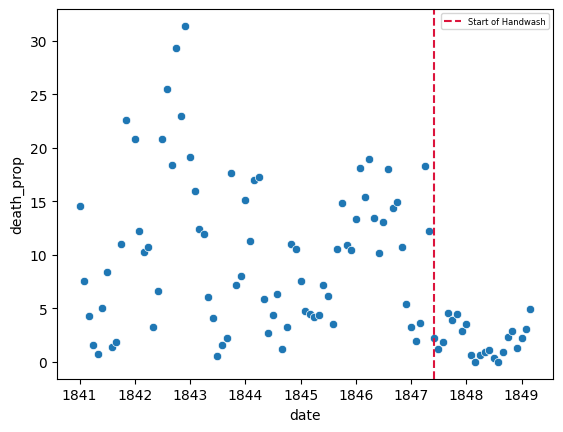

In [18]:
sns.scatterplot(data=df_monthly, x='date', y='death_prop')
plt.axvline(pd.Timestamp('1847-06-01'), color='crimson', linestyle='--', label='Start of Handwash')  
plt.legend(loc='upper right', prop={'size': 6})
plt.show()

##### We can clearly see, after the starting of handwashing  the death rates fall from an average 10-11% to far below 5% which is an enormous breakthrought and it has to be one of the solutions to make childbed fever rates lower.

##### From our previous analyses, we know that although there are increases in case numbers during certain times of the year, this does not provide any sufficient information to assume any logical statistical distribution. In these cases, we can use Kernel Density Estimation, which visualize the distribution of data assuming a normal distribution.

(0.005235602094240838, 0.18269230769230768)

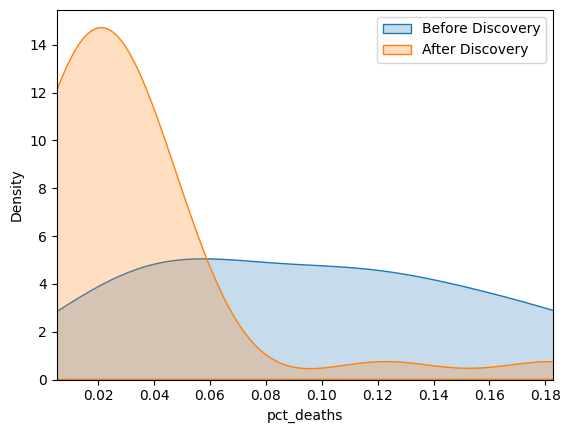

In [27]:
before_discovery['pct_deaths'] = before_discovery.deaths / before_discovery.births
after_discovery['pct_deaths'] = after_discovery.deaths / after_discovery.births

sns.kdeplot(before_discovery.pct_deaths, fill=True, label='Before Discovery')
sns.kdeplot(after_discovery.pct_deaths, fill=True, label='After Discovery')
plt.legend()
plt.xlim(min(before_discovery.pct_deaths), max(after_discovery.pct_deaths))

#####  This plot shows us that before the discovery the density of death rates was various and mostly it was moving between 4-14% in the records. The after discovery density diagram peaks at 2% which means after the discovery the most common value in the data about death rates was between 2-3%. 

##### As I mentioned before, from looking at the result of the plots earlier we can not spot any logical distribution type of the data. That means our data has a normal distribution. At this case especially at small datasets a T-Test could give us many useful information about the effectiveness of the discovery. 

In [20]:
t_value, p_value = stats.ttest_ind(a=before_discovery.pct_deaths, 
                                    b=after_discovery.pct_deaths)
print(f'The t-value is {t_value}')
print(f'The p-value is {p_value}')

The t-value is 5.219468164208575
The p-value is 1.0362134819416902e-06


##### The T-value tells us, there is a significant difference between the means of the two dataset. This information suggest for us, that the discovery was powerfull and the big positive difference indicates good effectiveness of handwashing.

#####  The P-value gives us to answer if it's Null Hipotesis (There is no difference between the examined data), or Alternativ Hipotesis (There is significant difference).  The critical value of P=0.05. In our case it's much lower, so we can reject the Null hipotesis which also suggest good efficiency of our discovery.